#### importing libraries

In [1]:
#importing basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

import os
import zipfile
import shutil
import re

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Bidirectional

Tensorflow version: 2.8.2
Keras version: 2.8.0


#### Downloading the dataset

In [2]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d columbine/imdb-dataset-sentiment-analysis-in-csv-format

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
imdb-dataset-sentiment-analysis-in-csv-format.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
local_zip = '/content/imdb-dataset-sentiment-analysis-in-csv-format.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
train_df = pd.read_csv("/tmp/Train.csv")
test_df = pd.read_csv("/tmp/Test.csv")
validation_df = pd.read_csv("/tmp/Valid.csv")

In [5]:
test_df.head()

,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


In [6]:
#this is to see the dsitribution of the positive and negative sentiment
print(train_df['label'].value_counts())

0    20019
1    19981
Name: label, dtype: int64


In [7]:
train_df["text"][0]

'I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.'

#### Preprocessing

In [8]:
#converting to lower case
def convert_lowercase(column):
    column = column.str.lower()
    return column

In [9]:
train_df['text']=convert_lowercase(train_df['text'])

In [10]:
#removing  urls
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

In [11]:
train_df['text']=train_df['text'].apply(remove_url)

In [12]:
#removing html tags if present
def clean_html(text):
    clean=re.compile('<.*?>')
    return re.sub(clean, '', text)

In [13]:
train_df['text']=train_df['text'].apply(clean_html)

In [14]:
#removing special characters
import string
exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

In [15]:
train_df['text']=train_df['text'].apply(remove_punc)

In [16]:
#removing stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_english = stopwords.words('english')

def remove_stopwords(text):
    new_text = []
    for word in text.split():
        if word in stopwords_english:
            continue
        else:
            new_text.append(word)

    return ' '.join(new_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
train_df['text']=train_df['text'].apply(remove_stopwords)

The following code can be implemented using textblob for spelling correction but is not done as it takes more than 2 days for computation using textblob

from textblob import TextBlob
def remove_spelling_error(text):
  textblob_ = TextBlob(text)
  return textblob_.correct().string

textblob_ = TextBlob(text)
train_df['text']=train_df['text'].apply(remove_spelling_error)

In [18]:
pip install pyspellchecker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
from spellchecker import SpellChecker
spell = SpellChecker()

def remove_spelling_error(text):
  return spell.correction(text)

train_df['text']=train_df['text'].apply(remove_spelling_error)

##### Test data

In [46]:
test_df['text']=convert_lowercase(test_df['text'])

In [47]:
test_df['text']=test_df['text'].apply(remove_url)

In [48]:
test_df['text']=test_df['text'].apply(clean_html)

In [49]:
test_df['text']=test_df['text'].apply(remove_punc)

In [50]:
test_df['text']=test_df['text'].apply(remove_stopwords)

#### tokenization and lemmatizing

In [20]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [21]:
train_df['text']=train_df['text'].apply(str)

In [22]:
def tokenize_and_lemmatize(text):
  punctuations="?:!.,;"
  sentence_words = nltk.word_tokenize(text)
  for word in sentence_words:
      if word in punctuations:
          sentence_words.remove(word)
  lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in sentence_words])
  return lemmatized_output

In [23]:
train_df['text']=train_df['text'].apply(tokenize_and_lemmatize)

In [24]:
train_df['text'][0]

'grew b 1965 watching loving thunderbird mate school watched played thunderbird school lunch school wanted virgil scott one wanted alan counting 5 became art form took child see movie hoping would get glimpse loved child bitterly disappointing high point snappy theme tune could compare original score thunderbird thankfully early saturday morning one television channel still play rerun series gerry anderson wife created jonatha frakes hand director chair version completely hopeless waste film utter rubbish cgi remake may acceptable replacing marionette homo sapiens subsp sapiens huge error judgment'

#### most common distribution of words

In [25]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [26]:
from nltk import FreqDist
words_list = []
for i in range(0,len(train_df["text"])):
  for w in train_df["text"][i]:
    words_list.append(w)

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

In [28]:
def get_top_n_words(x, n=None):
    vec = CountVectorizer(stop_words='english').fit(x)
    bag_of_words = vec.transform(x)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [29]:
common_words = get_top_n_words(train_df["text"], 20)
common_words

[('movie', 79352),
 ('film', 71714),
 ('like', 31964),
 ('time', 23537),
 ('good', 23001),
 ('character', 22118),
 ('story', 19358),
 ('make', 18953),
 ('really', 18391),
 ('scene', 16527),
 ('people', 14408),
 ('great', 14193),
 ('bad', 14106),
 ('dont', 13268),
 ('way', 13231),
 ('thing', 12938),
 ('think', 12044),
 ('life', 11543),
 ('know', 11297),
 ('watch', 10914)]

In [30]:
dfu = pd.DataFrame(common_words, columns = ['Unigram Text', 'Count'])
dfu
dfu.groupby('Unigram Text').sum()['Count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='The distribution of Top 20 Unigram')

In [31]:
def get_top_n_bigram(x, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(x)
    bag_of_words = vec.transform(x)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [32]:
common_words = get_top_n_bigram(train_df["text"], 20)
common_words

[('ive seen', 2672),
 ('look like', 2418),
 ('special effect', 1755),
 ('dont know', 1739),
 ('movie like', 1587),
 ('main character', 1514),
 ('year old', 1292),
 ('good movie', 1238),
 ('horror movie', 1218),
 ('film like', 1163),
 ('waste time', 1153),
 ('watch movie', 1139),
 ('horror film', 1129),
 ('bad movie', 1068),
 ('make movie', 1061),
 ('im sure', 1059),
 ('dont think', 1027),
 ('year ago', 1006),
 ('low budget', 1001),
 ('new york', 989)]

In [33]:
df2 = pd.DataFrame(common_words, columns = ['Bigram Text', 'Count'])
df2
df2.groupby('Bigram Text').sum()['Count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='The distribution of Top 20 Bigram')

#### splitting into train and test

In [34]:
#splitting into x_train and y_train
x_train = train_df['text']
y_train = train_df['label']

In [51]:
x_test = test_df['text']
y_test = test_df['label']

In [35]:
corpus = []
for text in train_df['text']:
  words = [word.lower() for word in nltk.word_tokenize(text)]
  corpus.append(words)

In [36]:
num_words = len(corpus)

In [37]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train,maxlen = 1000,padding='post',truncating='post')

In [38]:
x_test = tokenizer.texts_to_sequences(x_test)
x_train = pad_sequences(x_train,maxlen = 1000,padding='post',truncating='post')

#### LSTM

In [39]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(input_dim=num_words,output_dim=100,input_length=1000,trainable=True))

#model.add(LSTM(100,dropout=0.2,return_sequences=True))

model_lstm.add(tf.keras.layers.LSTM(units = 100, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 100, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 100, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 100, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 100, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 100, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 100, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 100, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 100, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 100, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 100, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 100, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 100, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 100, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 100, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 100)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(units=1,activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         4000000   
                                                                 
 lstm (LSTM)                 (None, 1000, 100)         80400     
                                                                 
 dropout (Dropout)           (None, 1000, 100)         0         
                                                                 
 lstm_1 (LSTM)               (None, 1000, 100)         80400     
                                                                 
 dropout_1 (Dropout)         (None, 1000, 100)         0         
                                                                 
 lstm_2 (LSTM)               (None, 1000, 100)         80400     
                                                                 
 dropout_2 (Dropout)         (None, 1000, 100)         0

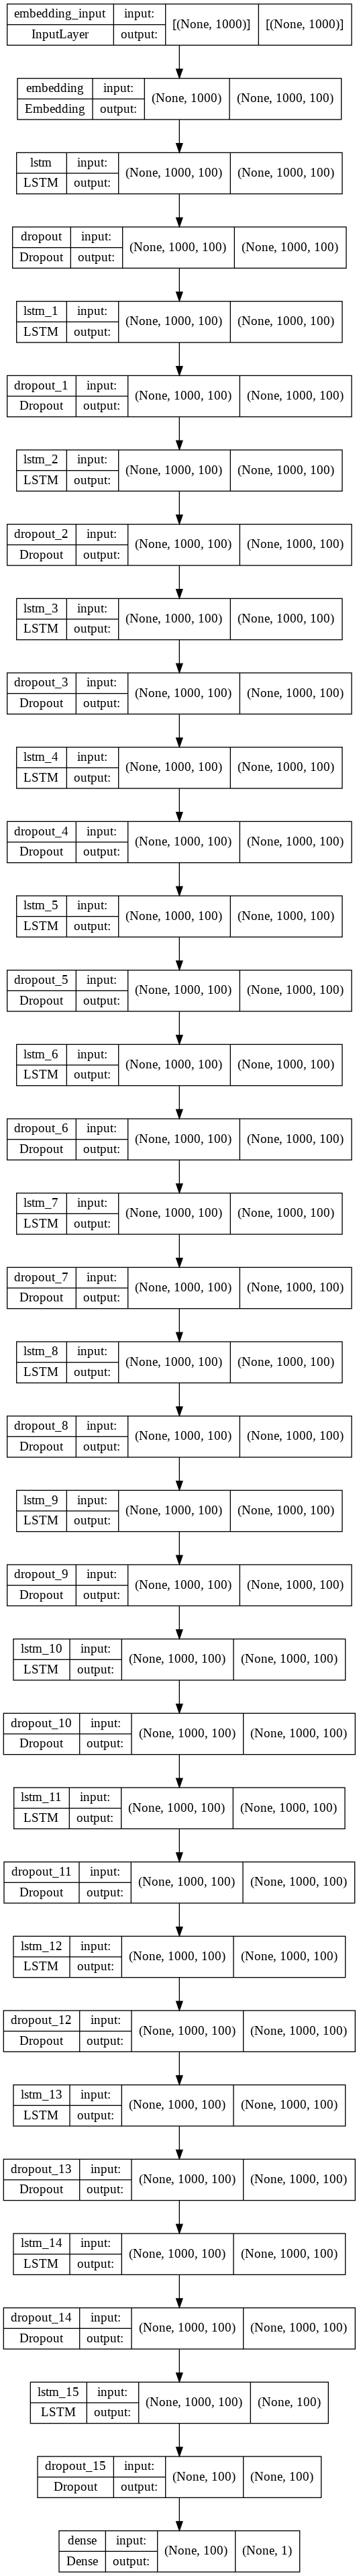

In [40]:
plot_model(model_lstm, show_shapes=True, show_layer_names=True)

In [41]:
model_lstm.fit(x_train, y_train,batch_size = 64)

625/625 [==============================] - 422s 643ms/step - loss: 0.6936 - accuracy: 0.4959


In [53]:
score, acc = model_lstm.evaluate(x_test, y_test,batch_size=64)

UnimplementedError: ignored

In [ ]:
print("score:",score)
print("Accuracy:",acc)

#### BidRNN

In [43]:
model_brnn = Sequential()
model_brnn.add(tf.keras.layers.Embedding(input_dim=num_words,output_dim=100,input_length=1000,trainable=True))

model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Dense(units=1,activation='sigmoid'))

model_brnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_brnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 100)         4000000   
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 200)        40200     
 l)                                                              
                                                                 
 dropout_16 (Dropout)        (None, 1000, 200)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 1000, 200)        60200     
 nal)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 1000, 200)         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 1000, 200)       

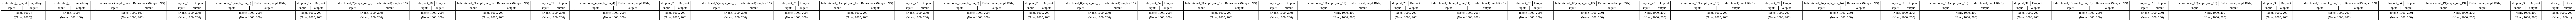

In [44]:
plot_model(model_brnn, show_shapes=True, show_layer_names=True,rankdir="LR")

In [45]:
model_brnn.fit(x_train, y_train,batch_size = 64)

625/625 [==============================] - 16795s 27s/step - loss: 0.7005 - accuracy: 0.4987


In [55]:
batch_size = 64
score1, acc1 = model_brnn.evaluate(x_test, y_test,batch_size=batch_size)

UnimplementedError: ignored

In [ ]:
print("score:",score1)
print("Accuracy:",acc1)

#### Dataset and Testing

In [56]:
validation_sentence = ['']
validation_sentence_tokened = tokenizer.texts_to_sequences(validation_sentence)
validation_sentence_padded = pad_sequences(validation_sentence_tokened,maxlen=1000,truncating='post',padding='post')
print(validation_sentence[0])
print("Possibility of Positive: {}".format(model_lstm.predict(validation_sentence_padded)[0]))
print("Possibility of Positive: {}".format(model_brnn.predict(validation_sentence_padded)[0]))



Possibility of Positive: [0.49700573]
Possibility of Positive: [[0.5025478 ]
 [0.5025545 ]
 [0.4999538 ]
 [0.4956229 ]
 [0.49956587]
 [0.50256926]
 [0.5051894 ]
 [0.49910966]
 [0.5025278 ]
 [0.50278777]
 [0.49782783]
 [0.50844127]
 [0.5002413 ]
 [0.5042345 ]
 [0.503996  ]
 [0.50264275]
 [0.5017154 ]
 [0.5037805 ]
 [0.5022364 ]
 [0.5085233 ]
 [0.50110596]
 [0.50838464]
 [0.5035902 ]
 [0.50453424]
 [0.5043915 ]
 [0.5013037 ]
 [0.50457865]
 [0.5000444 ]
 [0.50325143]
 [0.5007869 ]
 [0.50300866]
 [0.5015478 ]
 [0.50293624]
 [0.501797  ]
 [0.50268656]
 [0.50191647]
 [0.50238323]
 [0.50203806]
 [0.5022464 ]
 [0.5020677 ]
 [0.50215656]
 [0.5021367 ]
 [0.50211316]
 [0.50213754]
 [0.50207025]
 [0.5021959 ]
 [0.50205326]
 [0.50221735]
 [0.5020766 ]
 [0.50215036]
 [0.5021341 ]
 [0.5020993 ]
 [0.5021694 ]
 [0.5020844 ]
 [0.502175  ]
 [0.5020861 ]
 [0.5021702 ]
 [0.5020961 ]
 [0.5021622 ]
 [0.5021028 ]
 [0.5021565 ]
 [0.50210696]
 [0.5021547 ]
 [0.5021124 ]
 [0.5021475 ]
 [0.50212246]
 [0.5021362 

In [ ]:
validation_sentence = ['The film borrows from Indian mythology and folk tales, which is fantastic. The effort and passion invested in creating the universe in this film, replete with minute detailing, are worthy of appreciation. And while doing so, the makers lovingly doff their hats to movies like the Harry Potter franchise. The film shines in divisions like the VFX. The film’s colour palette has been created thoughtfully, and the depiction of the astras created out of the powers of nature and mythological characters is beautiful. The action choreography, especially in the chase sequence before interval, deserves whistles and claps, too.']
validation_sentence_tokened = tokenizer.texts_to_sequences(validation_sentence)
validation_sentence_padded = pad_sequences(validation_sentence_tokened,maxlen=1000,truncating='post',padding='post')
print(validation_sentence[0])
print("Possibility of Positive: {}".format(model_lstm.predict(validation_sentence_padded)[0]))
print("Possibility of Positive: {}".format(model_brnn.predict(validation_sentence_padded)[0]))
